In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import *
from qiskit.circuit.library import *
from qiskit.circuit import *
from qiskit.quantum_info import *
from qiskit.utils import *
from qiskit_machine_learning.algorithms import *
from qiskit_finance.circuit.library import *
from qiskit_finance.applications.estimation import *
from qiskit.algorithms.optimizers import *
from qiskit.algorithms import *

# QUANTUM GENERATIVE ADVERSARIAL NETWORKS

## Introduction

Generative Adversarial Neural Networks is a class of machine learning algorithms that arises at first time in 2014 by Ian Goodfellow. This type of algorithms consist of two neural networks, a generator and a discriminator, and they are able to generate, theoretically, any distribution data. They are mainly used for speech or image generation. The following image is an example of how efficient a GAN could be:

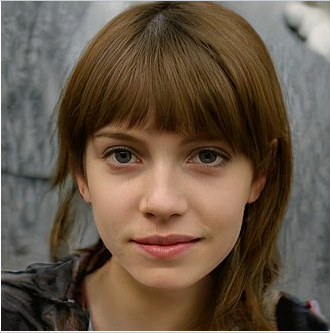

But, let's go a bit depeer with this understanding.

As mentioned previously, GANs are composed by two neural networks and each of them perform a certain task:

* **Discriminator**: discriminative algorithms try to classify data, meaning that given certain features of an event, the discriminator will predict the label or category the data belongs. For example, giving the an image of a dog (the pixels of the image are the features), the discriminator will predict the label of this image is a *dog*.
* **Generator**: generative algorithms have the goal to predict the features of a certain event, given a certain label or category of the distribution data. Following the previous example, in that case, we will insert the word *dog* in the generator and it will produce an image of a dog.

But... how do they work? Well, the following image illustrates perfectly how these two neural networks work together:

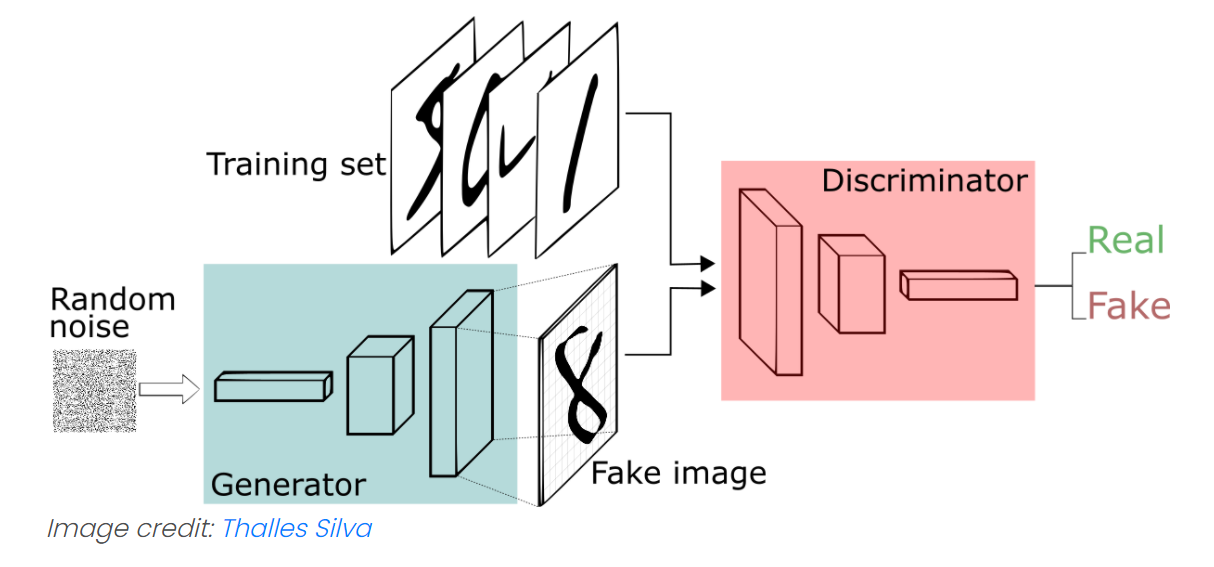

1. First of all, the discriminator needs to be trained by a set of real data. It is required to train the discriminator till a good accuracy is obtained. The discriminator will be the key component to train the generator.


2. Once the discriminator is trained, one gives to the generator random labels and it will generate the features.


3. The features of the generator are inserted into the discriminator which will say whether the features are real or not.


4. Depending on the output of the discriminator, the generator will be optimized till it achieves to fool always the discriminator.

The main aim of the generator is to fool the discriminator. If this is accomplished, it will mean that **the generator features are reproducing the same data probability distribution as the original raw data**. One key concept here is the **data probability distribution**: it is the goal of the generator, understand the raw data and predict how it will behave in the future because of its past probability distribution.

So, as both components that are interacting into the process are neural networks, they can also be converted into a quantum process; meaning converting them to *Quantum Neural Networks*. And here is where **qGANs** appear into Quantum Machine Learning. One can use quantum generators and discriminators or use a quantum generator with a classical discriminator. It relys on the problem to solve.

## Example of QGAN with classical discriminator

The following example we are going to purpose is a quantum generator (*qGAN*) and a classical discriminator. Its goal is to load into a quantum state a random distribution.

Converting classical data into quantum data is a very costly process (as we have seen in previous lectures). An example of that is the huge circuits we require to create in previous lessons (the feature map we use for our neural network examples) to perform good solutions in the evaluation side. Because of this, as neural networks are hybrid classical-quantum algorithms that will be able to be performed in NISQ devices, it would be a good start point performing the task of loading classical data into a quantum state with a very shallow circuit coming from a neural network. And this is the reason of this example.

Hence, let's go with that.

### Random log-normal distribution

In [ ]:
seed = 56
np.random.seed = seed

algorithm_globals.random_seed = seed

First of all, we would require to create the random data with a log-normal distribution:

$$p(x) = \frac{1}{\sigma \pi \sqrt{2\pi}} e^{-\frac{({\ln{(x)}-\mu})^2}{2{\sigma}^2}}$$

It is required to determine the dimension of the trainning data samples (1D - histogram, 2D - plot, 3D - volume...). For this example is $k=1$:

In [ ]:
# Load data samples from log-normal distribution
N = 5000 # size of the data sample
mu = 1 # mean of the data sample
sigma = 1 # standard deviation of the log-normal distribution

real_data = np.random.lognormal(mean=mu, sigma=sigma, size=N)

Now, we will define the quantum generator and discriminator as the following:

- **$G_{\alpha}$**: an ansatz, variational quantum circuit, as the quantum generator composed by the $\alpha$ parameter. In this example it is going to be build by $r_{y}$ and $c_{z}$ gates with $depth = 3$.


- **$D_{\psi}$**: a neural network as the classical discriminator composed by the $\psi$ parameter. In this example we are going to use the Numpy neural network.

<div class="alert alert-block alert-info">
    <b>IMPORTANT:</b> <i>qGans</i> are not easy quantum machine learning models (as <i>GANs</i> are not easy machine learning models). Because of this, it is very important to keep in mind that for $k>1$, the parameters needs to be chosen carefully, as well as increasing the number of parameters will yield to an increase of the depth circuit (to implement more complex structures).
</div>

In [ ]:
# Set the data resolution

# Set upper and lower data values as list of k min/max data values [[min_0,max_0],...,[min_k-1,max_k-1]]
bounds = np.array([0., 3.])
# Set number of qubits per data dimension as list of k qubit values[#q_0,...,#q_k-1]
num_qubits = [2] # 2 qubtis with dimension 1
k = len(num_qubits) # dimension = 1

# Set number of training epochs
num_epochs = 100
# Batch size
batch_size = 500

In [ ]:
# defining and setting the quantum generator

# Set entangler map
entangler_map = [[0, 1]]
# Set generator's initial parameters - in order to reduce the training time, it is important to choose them accordingly
init_params = [3., 1., 0.6, 1.6]
#init_params = np.random.rand(ansatz.num_parameters_settable) * 2 * np.pi

# Set the ansatz circuit
ansatz = TwoLocal(int(np.sum(num_qubits)), 'ry', 'cz', entanglement=entangler_map, reps=1, parameter_prefix='α')
# Set an initial state for the generator circuit
init_dist = UniformDistribution(sum(num_qubits))

# Set generator circuit by adding the initial distribution infront of the ansatz
g_circuit = ansatz.compose(init_dist, front=True)

generator = QuantumGenerator(bounds, num_qubits, generator_circuit=g_circuit, init_params=init_params)

In [ ]:
# defining the discriminator

discriminator = NumPyDiscriminator(len(num_qubits))

In [ ]:
# defining the whole QGAN

 # Initialize qGAN
qgan = QGAN(real_data, bounds, num_qubits, batch_size, num_epochs, seed=1, 
            discriminator=discriminator,
            generator = generator,
            snapshot_dir=None)

# Set quantum generator
#qgan.set_generator(generator_circuit=g_circuit, generator_init_params=init_params)
# Set classical discriminator neural network
#qgan.set_discriminator(discriminator)
# The parameters have an order issue that following is a temp. workaround
#qgan._generator._free_parameters = sorted(g_circuit.parameters, key=lambda p: p.name)

The loss functions of the generator and discriminator, respectively, are:

$$L_{G_{\alpha}}(\alpha,\psi) = -\frac{1}{m} \sum_{l=1}^m [\log({D_{\psi}(g^{l})})]$$


$$L_{D_{\psi}}(\alpha, \psi) = \frac{1}{m} \sum_{l=1}^m [\log{D_{\psi}(x^{l})+\log({1-D_{\psi}(g^{l})})}]$$

where $m$ is the batch size and $g^{l}$ are the samples generated by the generator.

<div class="alert alert-block alert-info">
    <b>Tip:</b> we have followed in this example the same guidance as in Qiskit tutorial to be able to execute it during the class, because of this initial parameters have been chosen. Without this prior knowledge, trainning phase would take some time as we will see in the following example.
</div>

In [ ]:
# runing the QGAN

# Set quantum instance to run the quantum generator
quantum_instance = QuantumInstance(backend=BasicAer.get_backend('statevector_simulator'), seed_transpiler=seed, 
                                   seed_simulator=seed)

result = qgan.run(quantum_instance)

In [ ]:
print('Training results:')
for key, value in result.items():
    print(key, value)

Hence, the *QGAN* is already trainned. So, let's se how the outcomes look like:

In [ ]:
# Plotting progress of generator's and discriminator's loss function
t_steps = np.arange(num_epochs)
plt.figure(figsize=(6,5))
plt.title("Progress in the loss function")
plt.plot(t_steps, qgan.g_loss, label='Generator loss function', color='mediumvioletred', linewidth=2)
plt.plot(t_steps, qgan.d_loss, label='Discriminator loss function', color='rebeccapurple', linewidth=2)
plt.grid()
plt.legend(loc='best')
plt.xlabel('time steps')
plt.ylabel('loss')
plt.show()

In [ ]:
# Plot progress w.r.t (with respect to) relative entropy
plt.figure(figsize=(6,5))
plt.title('Relative Entropy')
plt.plot(np.linspace(0, num_epochs, len(qgan.rel_entr)), qgan.rel_entr, color='mediumblue', lw=4, ls=':')
plt.grid()
plt.xlabel('time steps')
plt.ylabel('relative entropy')
plt.show()

**Relative entropy** is important because it is a good identifier of the disorder of the system. As much entropy we have between both components, the worst the generator is sampling.

In [ ]:
#Plot the Cummulative Distribution Function, menaing that how is the solution of the generator compared to the target 
#log-normal distribution
log_normal = np.random.lognormal(mean=1, sigma=1, size=100000)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= bounds[1]]
temp = []
for i in range(int(bounds[1] + 1)):
    temp += [np.sum(log_normal==i)]
log_normal = np.array(temp / sum(temp))

plt.figure(figsize=(6,5))
plt.title('CDF (Cumulative Distribution Function)')
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
samples_g = np.array(samples_g)
samples_g = samples_g.flatten()
num_bins = len(prob_g)
plt.bar(samples_g,  np.cumsum(prob_g), color='royalblue', width= 0.8, label='simulation')
plt.plot( np.cumsum(log_normal),'-o', label='log-normal', color='deepskyblue', linewidth=4, markersize=12)
plt.xticks(np.arange(min(samples_g), max(samples_g)+1, 1.0))
plt.grid()
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend(loc='best')
plt.show()

### Random logistic distribution

We will do the same as above, but with logistic random distribution:

In [ ]:
# defining metrics for logistic distribution
seed = 5687
np.random.seed = seed
algorithm_globals.random_seed = seed

# loading data samples from log-normal distribution
N = 5000 # size of the data sample
loc = 0.5 # location of the distribution
scale = 3 # scale of the logistic distribution

real_data = np.random.logistic(loc=loc, scale=scale, size=N)
bounds = np.array([0, 20.])
num_qubits = [2] 
num_epochs = 200
batch_size = 800

In [ ]:
# defining and setting the quantum generator

entangler_map = [[0, 1]]
init_params = np.random.rand(ansatz.num_parameters_settable) * 2 * np.pi

ansatz = TwoLocal(int(np.sum(num_qubits)), 'ry', 'cz', entanglement=entangler_map, reps=1, parameter_prefix='α')
init_dist = UniformDistribution(sum(num_qubits))

g_circuit = ansatz.compose(init_dist, front=True)

generator = QuantumGenerator(bounds, num_qubits, generator_circuit=g_circuit, init_params=init_params)

discriminator = NumPyDiscriminator(len(num_qubits))

In [ ]:
qgan = QGAN(real_data, bounds, num_qubits, batch_size, num_epochs, seed=1, 
            discriminator=discriminator,
            generator = generator,
            snapshot_dir=None)

quantum_instance = QuantumInstance(backend=BasicAer.get_backend('statevector_simulator'), seed_transpiler=seed, 
                                   seed_simulator=seed)

result = qgan.run(quantum_instance)

In [ ]:
print('Training results:')
for key, value in result.items():
    print(key, value)

In [ ]:
# plotting progress of generator's and discriminator's loss function
t_steps = np.arange(num_epochs)
plt.figure(figsize=(6,5))
plt.title("Progress in the loss function")
plt.plot(t_steps, qgan.g_loss, label='Generator loss function', color='mediumvioletred', linewidth=2)
plt.plot(t_steps, qgan.d_loss, label='Discriminator loss function', color='rebeccapurple', linewidth=2)
plt.grid()
plt.legend(loc='best')
plt.xlabel('time steps')
plt.ylabel('loss')
plt.show()

In [ ]:
# plot progress w.r.t (with respect to) relative entropy
plt.figure(figsize=(6,5))
plt.title('Relative Entropy')
plt.plot(np.linspace(0, num_epochs, len(qgan.rel_entr)), qgan.rel_entr, color='mediumblue', lw=4, ls=':')
plt.grid()
plt.xlabel('time steps')
plt.ylabel('relative entropy')
plt.show()

In [ ]:
# plot the Cummulative Distribution Function, menaing that how is the solution of the generator compared to the target 
# logistic distribution
log_normal = np.random.logistic(loc=0.5, scale=3, size=100000)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= bounds[1]]
temp = []
for i in range(int(bounds[1] + 1)):
    temp += [np.sum(log_normal==i)]
log_normal = np.array(temp / sum(temp))

plt.figure(figsize=(6,5))
plt.title('CDF (Cumulative Distribution Function)')
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
samples_g = np.array(samples_g)
samples_g = samples_g.flatten()
num_bins = len(prob_g)
plt.bar(samples_g,  np.cumsum(prob_g), color='royalblue', width= 0.8, label='simulation')
plt.plot( np.cumsum(log_normal),'-o', label='logistic', color='deepskyblue', linewidth=4, markersize=12)
plt.xticks(np.arange(min(samples_g), max(samples_g)+1, 1.0))
plt.grid()
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend(loc='best')
plt.show()

## Real use case: European Call Option Pricing

We will use a qGAN along *Quantum Amplitude Estimation* to solve an Option Pricing problem. The qGAN is going to calculate the probability distribution of the option price while the QAE will calculate the expected payoff.

Option pricing is a financial use case related to know the behavoiur of the option and thus, guess when the option will be worth. This is a fundamental tool for finance professionals and trading strategies. 

Mainly, the Black-Scholes model is used for this kind of problems. This model assumes that the spot price at maturity $S_{T}$ fro a European call option (options can be classified into European or American options because of their exercise time) is log-normally distributed. 

Hence, the Black-Scholes equation follows the same distribution as above.

Because of computational reasons, the gGAN has been already trained and the parameters are already given below:

In [ ]:
# Training parameters results of the qGAN
g_params = [0.29399714, 0.38853322, 0.9557694, 0.07245791, 6.02626428, 0.13537225]

In [ ]:
# Set upper and lower data values
bounds = np.array([0.,7.])
# Set number of qubits used in the uncertainty model
num_qubits = 3

# Set an initial state for the generator circuit and its ansatz
init_dist = NormalDistribution(num_qubits, mu=1., sigma=1., bounds=bounds)
ansatz = TwoLocal(num_qubits, 'ry', 'cz', entanglement='circular', reps=1)
# compose the generator circuit, this is the circuit loading the uncertainty model
g_circuit = ansatz.compose(init_dist, front=True)

Let's see how the probability distribution looks like:

In [ ]:
# keep a list of the parameters so we can associate them to the list of numerical values
theta = ansatz.ordered_parameters
# Extract the values, with the Statevector simulator, of the option pricing qGAN probability
values = [bounds[0] + (bounds[1] - bounds[0]) * x / (2 ** num_qubits - 1) for x in range(2**num_qubits)]
uncertainty_model = g_circuit.assign_parameters(dict(zip(theta, g_params)))
amplitudes = Statevector.from_instruction(uncertainty_model).data

x = np.array(values)
y = np.abs(amplitudes) ** 2

# Target probability distribution
N = 100000
log_normal = np.random.lognormal(mean=1, sigma=1, size=N)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= 7]
log_normal_samples = []
for i in range(8):
    log_normal_samples += [np.sum(log_normal==i)]
log_normal_samples = np.array(log_normal_samples / sum(log_normal_samples))

# Plot distributions
plt.bar(x, y, width=0.2, label='trained distribution', color='royalblue')
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel('Spot Price at Maturity $S_T$ (\$)', size=15)
plt.ylabel('Probability ($\%$)', size=15)
plt.plot(log_normal_samples,'-o', color ='deepskyblue', label='target distribution', linewidth=4, markersize=12)
plt.legend(loc='best')
plt.show()

The following cell is to illustrate analytically the expected value of the payoff:

In [ ]:
# Evaluate payoff for different distributions
payoff = np.array([0,0,0,1,2,3,4,5])
ep = np.dot(log_normal_samples, payoff)
print("Analytically calculated expected payoff w.r.t. the target distribution:  %.4f" % ep)
ep_trained = np.dot(y, payoff)
print("Analytically calculated expected payoff w.r.t. the trained distribution: %.4f" % ep_trained)

# Plot exact payoff function (evaluated on the grid of the trained uncertainty model) 
x = np.array(values)
y_strike = np.maximum(0, x - 2)
plt.plot(x, y_strike, 'ro-')
plt.grid()
plt.title('Payoff Function', size=15)
plt.xlabel('Spot Price', size=15)
plt.ylabel('Payoff', size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

Now, we are going to calculate the expected payoff of the option princing with the *Quantum Amplitude Estimation*:

In [ ]:
qi = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=100)

# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 2
# set the approximation scaling for the payoff function
c_approx = 0.25
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

# construct circuit for payoff function
european_call_pricing = EuropeanCallPricing(num_qubits, strike_price=strike_price,rescaling_factor=c_approx,
                                            bounds=bounds, uncertainty_model=uncertainty_model)
problem = european_call_pricing.to_estimation_problem()
ae = IterativeAmplitudeEstimation(epsilon, alpha=alpha, quantum_instance=qi)
result = ae.estimate(problem)

In [ ]:
conf_int = np.array(result.confidence_interval_processed)
print('Exact value:        \t%.4f' % ep_trained)
print('Estimated value:    \t%.4f' % (result.estimation_processed))
print('Confidence interval:\t[%.4f, %.4f]' % tuple(conf_int))

### Reference

https://en.wikipedia.org/wiki/Generative_adversarial_network

https://wiki.pathmind.com/generative-adversarial-network-gan

https://qiskit.org/documentation/tutorials/machine_learning/04_qgans_for_loading_random_distributions.html

https://arxiv.org/pdf/1904.00043.pdf

https://qiskit.org/documentation/machine-learning/tutorials/04_qgans_for_loading_random_distributions.html

https://qiskit.org/documentation/tutorials/finance/10_qgan_option_pricing.html

https://github.com/Qiskit/qiskit-finance/blob/master/docs/tutorials/10_qgan_option_pricing.ipynb